[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/diogoflim/PO_II/blob/main/3_Otimização_Redes/Fluxo_Max_CorteMin/MaxFlow_CorteMin.ipynb)

In [73]:
import networkx as nx
import matplotlib.pyplot as plt


In [74]:
# Cria um objeto de grafo direcionado
G = nx.DiGraph()

# Adiciona nós ao grafo
G.add_node('s')  # Nó fonte
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')
G.add_node('t')  # Nó destino

# Adiciona arestas ao grafo com suas capacidades
G.add_edge('s', 'a', capacidade=3)
G.add_edge('s', 'b', capacidade=2)
G.add_edge('a', 'b', capacidade=1)
G.add_edge('a', 'c', capacidade=3)
G.add_edge('b', 'd', capacidade=2)
G.add_edge('c', 'd', capacidade=2)
G.add_edge('c', 't', capacidade=3)
G.add_edge('d', 't', capacidade=3)


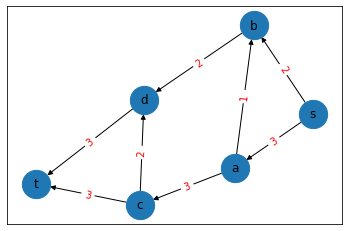

In [78]:
# Desenha o grafo com os rótulos de capacidade nas arestas

pos =  nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_size = 800)
aresta_rotulos = {(u, v): d['capacidade'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=aresta_rotulos, font_color='red')
plt.show()


### Fluxo Máximo

In [79]:
# Calcula o fluxo máximo
fluxo_max, fluxo_dict = nx.maximum_flow(G, 's', 't', capacity = 'capacidade')


In [80]:
# Imprime os resultados
print("Fluxo máximo:", fluxo_max)
print("Dicionário de fluxo:", fluxo_dict)


Fluxo máximo: 5
Dicionário de fluxo: {'s': {'a': 3, 'b': 2}, 'a': {'b': 0, 'c': 3}, 'b': {'d': 2}, 'c': {'d': 0, 't': 3}, 'd': {'t': 2}, 't': {}}


### Corte Mínimo

In [81]:
# Corte mínimo
corte_min, part = nx.minimum_cut(G, 's', 't', capacity = 'capacidade')



In [82]:
# Imprime os resultados
print("Valor do Corte Mínimo:", corte_min)
print("Partição dos vértices a partir do corte mínimo:", part)


Valor do Corte Mínimo: 5
Partição dos vértices a partir do corte mínimo: ({'s', 'a', 'b'}, {'d', 't', 'c'})
